Make depth profiles of ocean velocities in all 10 runs, plus composites. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import Functions_data_analysis as fda
import Functions_plotting as fp
from Datasets import exp_set_dict_warm_order
import xarray as xr
import gsw
import sys
import os

In [2]:
# For importing density function
sys.path.append('/glade/u/home/gemmao/MITgcm/utils/python/MITgcmutils/MITgcmutils')
from jmd95 import densjmd95

In [3]:
import importlib
importlib.reload(fda)

<module 'Functions_data_analysis' from '/glade/campaign/univ/uwas0134/Gemma/Analysis/Functions_data_analysis.py'>

In [4]:
exp_set = 'ic_2001'#e.g., ic_1995, control
region = 'ET_2'
# region = 'lat_5'

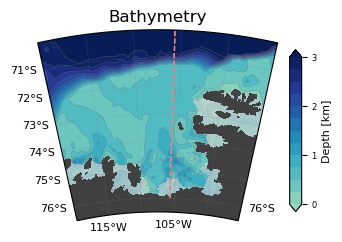

In [5]:
bathy_map = fp.plot_bathymetry_and_locs('bathy_map', [region,'ET_2'])
# plt.savefig('Plots/Figure_bathymetry_map_with_locs.png',dpi=400)

In [6]:
# Ocean T, S, U
prefix = 'state_3d_set2' # To plot ocean T, U, or V at a given depth
runs = exp_set_dict_warm_order[exp_set]
print(runs)
save_new_ens_da = True 

vars = ['T','S','U'] # all analyses follow this order
all_run_da_list = []
for var in vars:
    fname = 'Saved Arrays/Ensemble_data/'+var+'_'+exp_set+'_'+region+'_60_months.nc'
    try:
        all_run_da = xr.open_dataset(fname)[var]
        print(fname,'found')
    except:
        print('loading new data array for',var)
        all_run_da = fda.get_ensemble_data_for_ic(var, runs, region, prefix, month_start_idx = month_start_idx, n_months=n_months)
        if save_new_ens_da:
            all_run_ds = xr.Dataset({var: all_run_da})
            all_run_ds.to_netcdf(fname)
            # all_run_da.to_netcdf(fname,'w',data_vars={var:all_run_da.name})
            print('Saved as',fname)
    
    # these have shape (10 runs, 60 times, 70 depths, 256 lats)
    all_run_da_list.append(all_run_da)

print('Data retrieved!')

['run_forc_erai_1982_rep_ic_2001', 'run_forc_erai_1984_rep_ic_2001', 'run_forc_erai_1989_rep_ic_2001', 'run_forc_erai_1992_rep_ic_2001', 'run_forc_erai_1994_rep_ic_2001', 'run_forc_erai_2003_rep_ic_2001', 'run_forc_erai_2009_rep_ic_2001', 'run_forc_erai_1991_rep_ic_2001', 'run_forc_erai_2015_rep_ic_2001', 'run_forc_erai_2011_rep_ic_2001']
Saved Arrays/Ensemble_data/T_ic_2001_ET_2_60_months.nc found
Saved Arrays/Ensemble_data/S_ic_2001_ET_2_60_months.nc found
Saved Arrays/Ensemble_data/U_ic_2001_ET_2_60_months.nc found
Data retrieved!


In [7]:
# Calculate annual avgs, ens mean for each yr, and calculate warm/cool composites in anomalies

#order (T,S,U). each item has shape (5 yrs, lons, lats)
ens_mean_list = [] 
warm_list = []
warm_anom_list = [] 
cool_list = []
cool_anom_list = []

for i in range(len(vars)):

    # Load variable data: (10 runs, 60 times, lons, lats) 
    var_i_data = all_run_da_list[i]

    # avg over time for each yr: (10, 60, lons, lats) -> (10, 5, lons, lats)
    var_all_run_ann_mean = var_i_data.resample(time='12M').mean(dim='time')

    # calculate ens means of annual avgs: (10, 5, lons, lats) -> (5 yrs, lons, lats)
    var_ens_mean = var_all_run_ann_mean.mean(dim='run')
    ens_mean_list.append(var_ens_mean) #leave off year 6 which is just one month

    # calculate composites: (10 runs, 5 yrs, lons, lats) -> (5 yrs, lons, lats)
    var_warm_comp_runs = var_all_run_ann_mean.isel(run = slice(0,4))
    var_warm_comp = var_warm_comp_runs.mean(dim='run')
    var_cool_comp_runs = var_all_run_ann_mean.isel(run = slice(4,8))
    var_cool_comp = var_cool_comp_runs.mean(dim='run')
    warm_list.append(var_warm_comp)
    cool_list.append(var_cool_comp)
    if i == 0:
        print('Warm composite runs:',var_warm_comp_runs.run.values)
        print('Cool composite runs:',var_cool_comp_runs.run.values)

    # Put composites in anomalies: (5 yrs, lons, lats)
    var_warm_anom = var_warm_comp - var_ens_mean
    var_cool_anom = var_cool_comp - var_ens_mean

    warm_anom_list.append(var_warm_anom)
    cool_anom_list.append(var_cool_anom)


Warm composite runs: ['run_forc_erai_1982_rep_ic_2001' 'run_forc_erai_1984_rep_ic_2001'
 'run_forc_erai_1989_rep_ic_2001' 'run_forc_erai_1992_rep_ic_2001']
Cool composite runs: ['run_forc_erai_1994_rep_ic_2001' 'run_forc_erai_2003_rep_ic_2001'
 'run_forc_erai_2009_rep_ic_2001' 'run_forc_erai_1991_rep_ic_2001']


In [8]:
cmap_dict = {'U':'BrBG_r','V':'PiYG_r','T':'RdBu_r','S':'viridis_r'}


lev_dict = {'U':np.linspace(-0.08,0.08,11),'V':np.linspace(-0.1,0.1,9),\
           'T':np.linspace(-1.5,1.5,11),'S':np.arange(34.2,35,0.1)}

anom_lev_dict = {'U':np.linspace(-0.04,0.04,9),'V':np.linspace(-0.04,0.04,9),\
                 'T':np.linspace(-0.4,0.4,9),'S':np.arange(-0.1,0.2,0.05)}

xlims_dict = {'ET':[-75.8,-70.5],'lat':[-110.2,-98]}
xlims = xlims_dict[region.split('_')[0]]

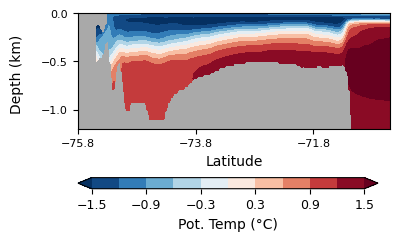

In [9]:
# Plot ensemble mean time avged T
importlib.reload(fp)

# fig_name='Plots/Figure_3a_T_ens_mean.png'
fig_name = None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height= 1,1,4,2.22,0.45,0.2,.18,.05
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

fp.make_side_profile_figs([ens_mean_list[0].mean(dim='time')], 'T',plot_format,
                          levs=lev_dict['T'],subplot_labels = [''],cmap=cmap_dict['T'], 
                          ylims=[-1.2,0],xlims=xlims,
                          fig_name = fig_name)

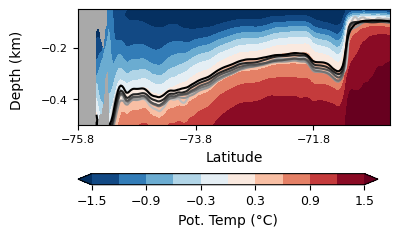

In [10]:
# Plot ensemble mean time avged T with thermocline contours over time
importlib.reload(fp)

# fig_name='Plots/Figure_3x_S_ens_mean_with_stacked_isopycnals.png'
fig_name=None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height= 1,1,4,2.22,0.45,0.2,.18,.05
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

fp.make_side_profile_figs([ens_mean_list[0].mean(dim='time')], 'T',plot_format,
                          T_data=warm_list[0],T_levs = [0.5,],
                          levs=lev_dict['T'],subplot_labels = [''],cmap=cmap_dict['T'], 
                          ylims=[-0.5,-0.05],xlims=xlims,fig_name = fig_name)

In [11]:
# Ensemble mean density
em_temp = ens_mean_list[0].mean(dim = 'time') #(70 depths, 256 lats)
em_sal = ens_mean_list[1].mean(dim = 'time') #(70,256)
em_temp_masked = em_temp.where(em_temp != 0)
em_sal_masked = em_sal.where(em_sal != 0)
em_dens = densjmd95(em_sal_masked, em_temp_masked, 0) - 1000


# get warm density
warm_temp = warm_list[0] #(70 depths, 256 lats)
warm_sal = warm_list[1]#(70,256)
warm_temp_masked = warm_temp.where(warm_temp != 0)
warm_sal_masked = warm_sal.where(warm_sal != 0)
# Get Warm composite density each year
warm_dens_all_yrs = []
for year in range(6):
    warm_dens_year = densjmd95(warm_sal_masked[year], warm_temp_masked[year], 0) - 1000
    warm_dens_all_yrs.append(warm_dens_year)

# get cool density
cool_temp = cool_list[0] #(70 depths, 256 lats)
cool_sal = cool_list[1]#(70,256)
cool_temp_masked = cool_temp.where(cool_temp != 0)
cool_sal_masked = cool_sal.where(cool_sal != 0)
# Get cool composite density each year
cool_dens_all_yrs = []
for year in range(6):
    cool_dens_year = densjmd95(cool_sal_masked[year], cool_temp_masked[year], 0) - 1000
    cool_dens_all_yrs.append(cool_dens_year)
    

(-1200.0, 0.0)

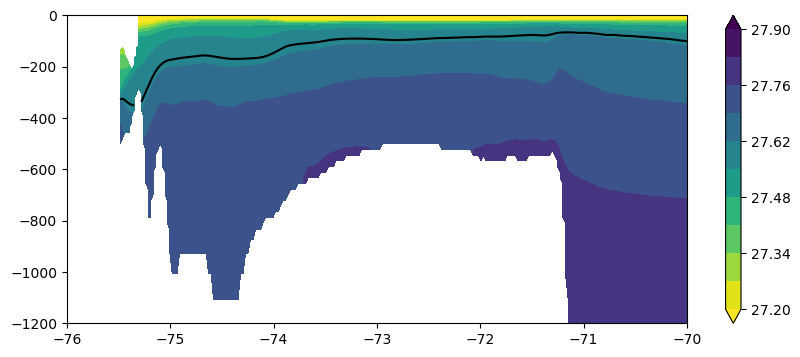

In [12]:
# Plot ensemble mean density
plot_data = em_dens
plt.figure(figsize=(10,4))
plt.contourf(em_temp.lat, em_temp.depth,plot_data,levels=np.linspace(27.2,27.9,11),cmap='viridis_r',extend='both')
plt.colorbar()
plt.contour(em_temp.lat, em_temp.depth,plot_data,levels=[27.6],colors='k')
plt.xlim([-76,-70])
plt.ylim([-1200,0])


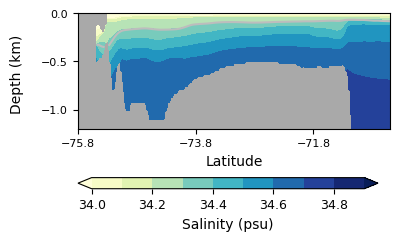

In [13]:
# Plot ensemble mean time avged S
importlib.reload(fp)

# fig_name='Plots/Figure_3c_S_ens_mean.png'
fig_name=None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height= 1,1,4,2.22,0.45,0.2,.18,.05
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

fp.make_side_profile_figs([ens_mean_list[1].mean(dim='time')], 'S',plot_format,
                          T_data=[em_dens], T_levs=[27.6],
                          levs=np.arange(34,35,0.1),subplot_labels = [''],cmap='YlGnBu', 
                          ylims=[-1.2,0],xlims=xlims,fig_name = fig_name)

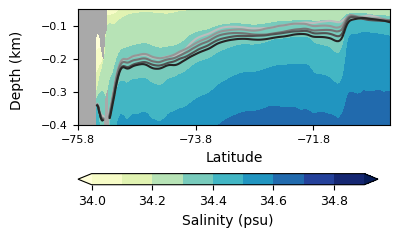

In [14]:
# Plot ensemble mean time avged S
importlib.reload(fp)

# fig_name='Plots/Figure_3x_S_ens_mean_with_stacked_isopycnals.png'
fig_name=None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height= 1,1,4,2.22,0.45,0.2,.18,.05
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

fp.make_side_profile_figs([ens_mean_list[1].mean(dim='time')], 'S',plot_format,
                          T_data=warm_dens_all_yrs[1:],T_levs = [27.6,],
                          levs=np.arange(34,35,0.1),subplot_labels = [''],cmap='YlGnBu', 
                          ylims=[-0.4,-0.05],xlims=xlims,fig_name = fig_name)

Text(0.5, 1.0, 'Ensemble mean U velocity')

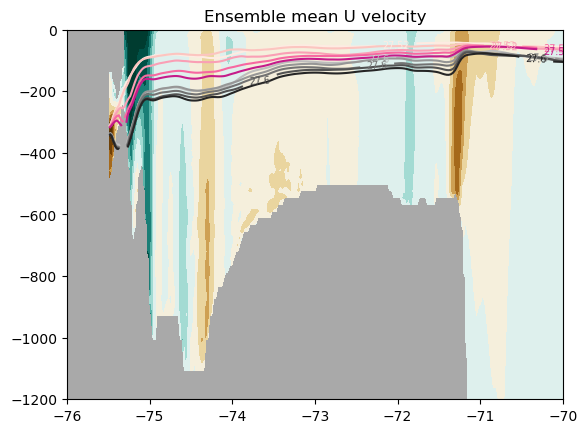

In [16]:
# Plot ensemble mean U velocity with warm composite density contours over time. pink = 27.52 isopycnal, black = 27.6 isopycnal.
fig = plt.figure()
em_u = ens_mean_list[2].mean(dim='time')
em_u = em_u.where(em_u != 0)
ulevs = np.linspace(-0.08,0.08,11)
cf = plt.contourf(em_temp.lat, em_temp.depth, em_u,levels = ulevs,cmap='BrBG_r',extend='both')
plt.gca().set_facecolor('darkgray')
# plt.contour(em_temp.lat, em_temp.depth, em_dens,levels = [27.65,],colors='k')
colors1 = ['#feebe2','#fcc5c0','#fa9fb5','#f768a1','#c51b8a','#7a0177']
colors2 = ['#bdbdbd','#969696','#737373','#525252','#252525','k']
for i in range(5):
    cp0 = plt.contour(em_temp.lat, em_temp.depth, warm_dens_all_yrs[i+1],levels = [27.52,],colors=colors1[i])
    plt.clabel(cp0, inline=True, fontsize=7)
    cp = plt.contour(em_temp.lat, em_temp.depth, warm_dens_all_yrs[i+1],levels = [27.6,],colors=colors2[i])
    plt.clabel(cp, inline=True, fontsize=7)
plt.xlim([-76,-70])
plt.ylim([-1200,0])
plt.title('Ensemble mean U velocity')


saving as Plots/Figure_3e_U_ens_mean.png


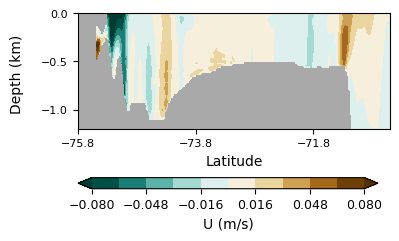

In [17]:
# Plot ensemble mean time avged U
importlib.reload(fp)
fig_name = 'Plots/Figure_3e_U_ens_mean.png'
# fig_name=None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height= 1,1,4,2.22,0.45,0.2,.18,.05
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

fp.make_side_profile_figs([ens_mean_list[2].mean(dim='time')], 'U',plot_format,
                          # T_data = warm_dens_all_yrs,T_levs = [27.6,],
                          levs=lev_dict['U'],
                          subplot_labels = [''],cmap=cmap_dict['U'], 
                          ylims=[-1.2,0],xlims=xlims,fig_name = fig_name)
colors2 = ['#bdbdbd','#969696','#737373','#525252','#252525','k']
for i in range(5):
    cp0 = plt.contour(em_temp.lat, em_temp.depth, warm_dens_all_yrs[i+1],levels = [27.52,],colors=colors1[i])
    plt.clabel(cp0, inline=True, fontsize=7)
    cp = plt.contour(em_temp.lat, em_temp.depth, warm_dens_all_yrs[i+1],levels = [27.6,],colors=colors2[i])
    plt.clabel(cp, inline=True, fontsize=7)

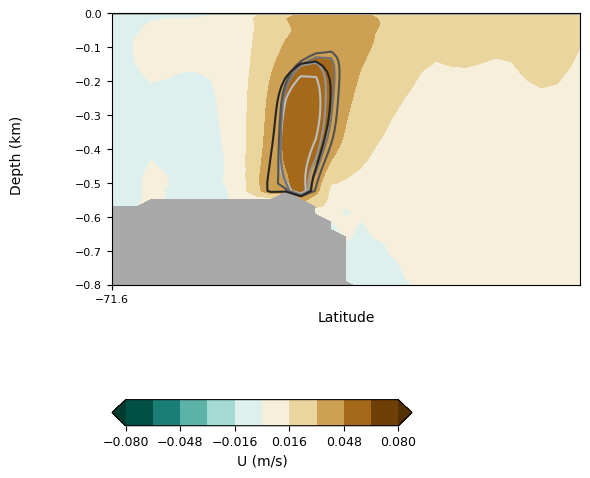

In [18]:
# Plot ensemble mean time avged U with 0.04 contours over time
importlib.reload(fp)

# fig_name='Plots/Figure_3x_S_ens_mean_with_stacked_isopycnals.png'
fig_name=None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height= 1,1,6,5.22,0.45,0.2,.18,.05
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

fp.make_side_profile_figs([ens_mean_list[2].mean(dim='time')], 'U',plot_format,
                          T_data=warm_list[2][1:],T_levs = [0.06,],
                          levs=lev_dict['U'],subplot_labels = [''],cmap=cmap_dict['U'], 
                          ylims=[-0.8,0],xlims=[-71.6,-70.8],fig_name = fig_name)

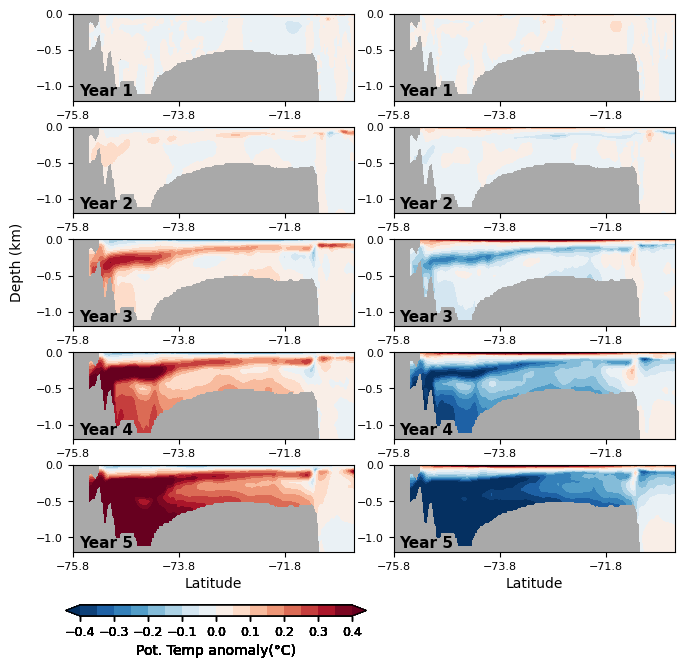

In [19]:
# Plot T anomaly profiles in warm composite (left) and cool composite (Right)
importlib.reload(fp)

# Plot T colors 

# Edit fig name for saving!!
fig_name = None
# fig_name = 'Plots/Figure_3b_T_all_yrs.png'

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.11,.08,0.015
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

plot_t_anom = []
plot_t = []
for i in range(5):
    plot_t_anom.append(warm_anom_list[0][i])
    plot_t_anom.append(cool_anom_list[0][i])
    plot_t.append(warm_list[0][i])
    plot_t.append(cool_list[0][i])
    
sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_t_anom, 'T anomaly',plot_format,
                          levs=np.arange(-0.4,.45,0.05),
                          # T_data = plot_t,T_levs=[0.5],
                          subplot_labels = sp_labs,cmap=cmap_dict['T'], \
                          ylims=[-1.2,0],xlims=xlims,\
                          fig_name = fig_name)

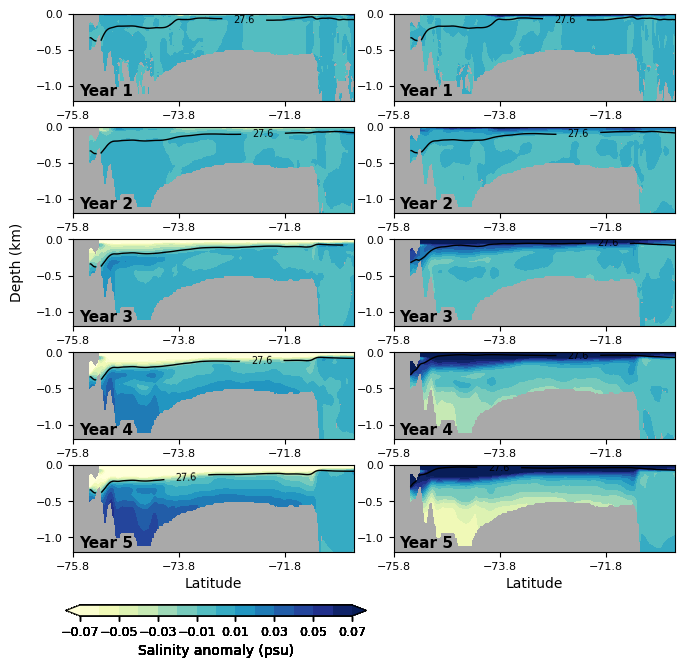

In [27]:
# Plot S anomaly profiles in warm composite (left) and cool (right)

importlib.reload(fp)

# Plot S

# Edit fig name for saving!!
# fig_name = 'Plots/Figure_3d_S_all_yrs.png'
fig_name = None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.11,.08,0.015
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

plot_s_anom = []
plot_s = []
plot_dens = []
for i in range(5):
    plot_s_anom.append(warm_anom_list[1][i])
    plot_s_anom.append(cool_anom_list[1][i])
    plot_s.append(warm_list[1][i])
    plot_s.append(cool_list[1][i])
    plot_dens.append(warm_dens_all_yrs[i])
    plot_dens.append(cool_dens_all_yrs[i])
    
sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_s_anom, 'S anomaly',plot_format,levs=np.arange(-0.07,0.07,0.01),
                          T_data=plot_dens, T_levs=[27.6],
                          subplot_labels = sp_labs,cmap='YlGnBu', \
                          ylims=[-1.2,0],xlims=xlims,\
                          fig_name = fig_name)

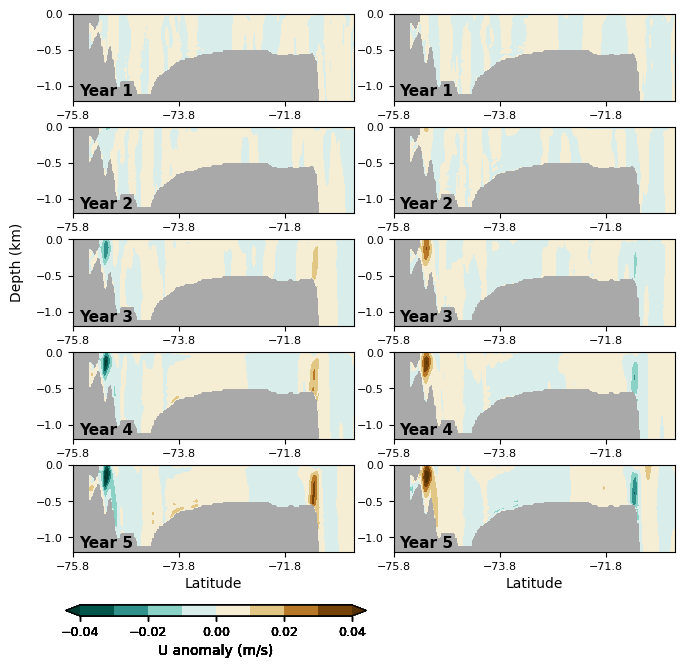

In [34]:
# Plot U anom profiles in warm composite (left) and cool composite (right)
importlib.reload(fp)

# Plot U with T contours

# Edit fig name for saving!!
# fig_name = 'Plots/Figure_U_comp_all_yrs_'+region+'_'+exp_set+'.png'
# fig_name = 'Plots/Figure_3f_U_all_years.png'
fig_name = None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.11,.08,0.015
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

plot_u = []
plot_u_anom = []
for i in range(5):
    plot_u.append(warm_list[2][i])
    plot_u.append(cool_list[2][i])
    plot_u_anom.append(warm_anom_list[2][i])
    plot_u_anom.append(cool_anom_list[2][i])

    
sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_u_anom, 'U anomaly',plot_format,
                          levs=anom_lev_dict['U'],\
                          subplot_labels = sp_labs,cmap=cmap_dict['U'], \
                          ylims=[-1.2,0],xlims=xlims,\
                          fig_name = fig_name)

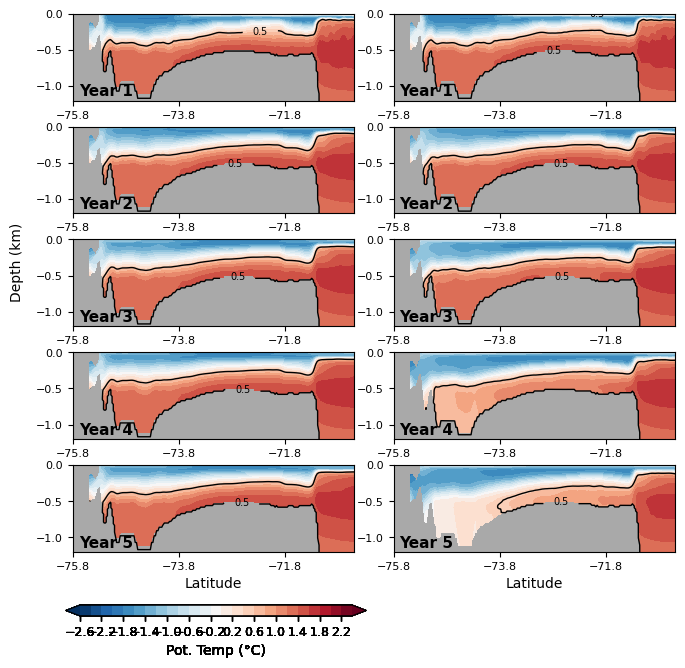

In [48]:
# Plot actual T profiles in warm composite (left) and cool composite (right)

importlib.reload(fp)


# Edit fig name for saving!!
fig_name = None
# fig_name = 'Plots/Figure_3b_T_actual_values_all_yrs.png'

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.11,.08,0.015
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

plot_t_anom = []
plot_t = []
for i in range(5):
    plot_t_anom.append(warm_anom_list[0][i])
    plot_t_anom.append(cool_anom_list[0][i])
    plot_t.append(warm_list[0][i])
    plot_t.append(cool_list[0][i])
    
sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_t, 'T',plot_format,
                          levs=np.arange(-2.6,2.6,0.2),
                          T_data = plot_t,T_levs=[0.5],
                          subplot_labels = sp_labs,cmap=cmap_dict['T'], \
                          ylims=[-1.2,0],xlims=xlims,\
                          fig_name = fig_name)

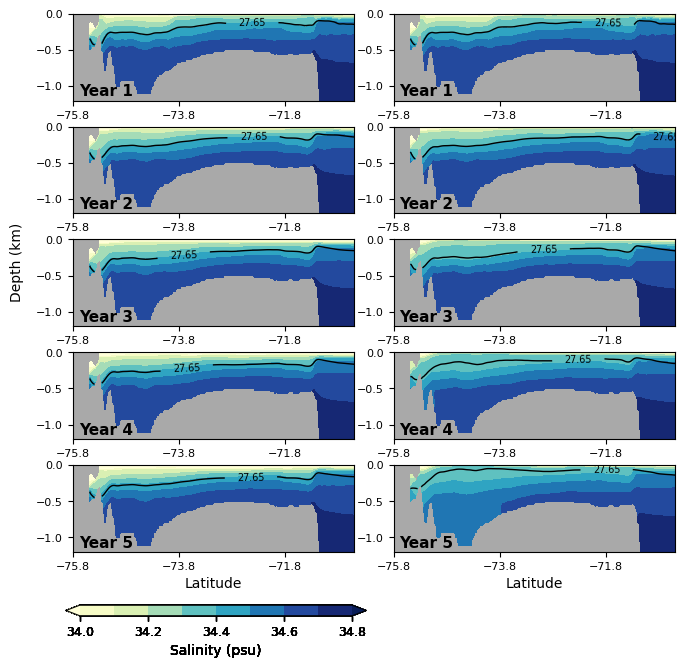

In [47]:
# Plot S (actual values) profiles in warm composite (left) and cool (right)

importlib.reload(fp)

# Plot S

# Edit fig name for saving!!
# fig_name = 'Plots/Figure_3d_S_all_yrs.png'
fig_name = None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.11,.08,0.015
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_s, 'S',plot_format,levs=np.arange(34,34.9,0.1),
                          T_data=plot_dens, T_levs=[27.65],
                          subplot_labels = sp_labs,cmap='YlGnBu', \
                          ylims=[-1.2,0],xlims=xlims,\
                          fig_name = fig_name)

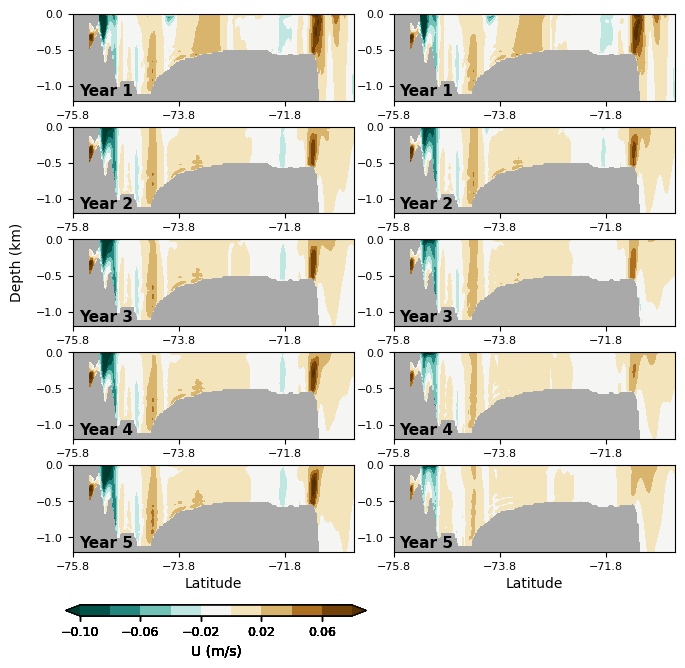

In [37]:
# Plot U actual value profiles in warm composite (left) and cool composite (right)
importlib.reload(fp)

# Plot U with T contours

# Edit fig name for saving!!
# fig_name = 'Plots/Figure_U_comp_all_yrs_'+region+'_'+exp_set+'.png'
# fig_name = 'Plots/Figure_3f_U_all_years.png'
fig_name = None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.11,.08,0.015
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]
    
sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_u, 'U',plot_format,
                          levs=np.arange(-0.1,0.1,0.02),\
                          subplot_labels = sp_labs,cmap=cmap_dict['U'], \
                          ylims=[-1.2,0],xlims=xlims,\
                          fig_name = fig_name)

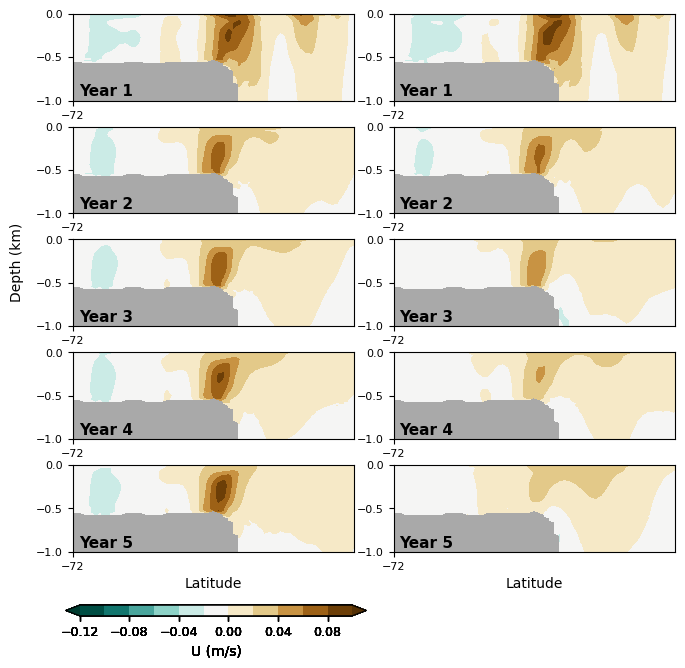

In [42]:
# Plot zoomed in U actual value profiles in warm composite (left) and cool composite (right)
importlib.reload(fp)

# Plot U with T contours

# Edit fig name for saving!!
fig_name = None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.11,.08,0.015
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]
    
sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_u, 'U',plot_format,
                          levs=np.arange(-0.12,0.12,0.02),\
                          subplot_labels = sp_labs,cmap=cmap_dict['U'], \
                          ylims=[-1,0],xlims=[-72,-70.6],\
                          fig_name = fig_name)